In [1]:
!pip install pyDOE

In [33]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.8.0


# *Data Prep*

Training and Testing data is prepared from the solution file

In [34]:
from scipy.stats import norm
#getting collocation points
x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
t = np.linspace(0, 0.1, 1000)                     # 100 time points between 0 and 1 [100x1] 
usol=np.zeros((256,1000))
usol[:,0][:]=norm.pdf(x,0,0.05).T

#collocation points for every position and every time
X, T = np.meshgrid(x,t)

# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

In [35]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_test[0]  # [-1. 0.]
ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u = usol.flatten('F')[:,None] 

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [36]:
def trainingdata(N_u,N_f):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x =<1 and t = 0  
    leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
    leftedge_u = usol[:,0][:,None]

    #Boundary Condition x = -1 and 0 =< t =<1
    bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
    bottomedge_u = usol[-1,:][:,None]

    #Boundary Condition x = 1 and 0 =< t =<1
    topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
    topedge_u = usol[0,:][:,None]

    all_X_u_train = np.vstack([leftedge_x, bottomedge_x, topedge_x]) # X_u_train [456,2] (456 = 256(L1)+100(L2)+100(L3))
    all_u_train = np.vstack([leftedge_u, bottomedge_u, topedge_u])   #corresponding u [456x1]

    #choose random N_u points for training
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) 

    X_u_train = all_X_u_train[idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[idx,:]      #choose corresponding u

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f) 
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    return X_f_train, X_u_train, u_train 


# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [37]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
        self.itera = 1
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    def loss_PDE(self, x_to_train_f):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
    
        cost=1 
        sigma2=0.1

        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            p_x = tape.gradient(z,x_f)

        p_t = tape.gradient(z,t_f)    
        p_xx = tape.gradient(p_x, x_f)

        del tape

        p=self.evaluate(g)

        f = p_t - cost * p - cost * x_f * p_x - sigma2/2*p_xx

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    def loss(self,x,y,g):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        
        tf.print(self.itera, loss_value, loss_u, loss_f, error_vec)
        self.itera += 1

# *Solution Plot*

In [38]:
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(2, 3)
    gs0.update(top=1, bottom=0, left=0.1, right=2, wspace=0.3, hspace =0.4)
    ax = plt.subplot(gs0[0, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    #ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    #ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    #gs1 = gridspec.GridSpec(1, 3)
    #gs1.update(top=0.3, bottom=-0.1, left=0.1, right=2, wspace=0.5)

    ax = plt.subplot(gs0[1, 0])
    #ax.plot(x,usol.T[0,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[0,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.s$', fontsize = 10)
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])

    ax = plt.subplot(gs0[1, 1])
    #ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[500,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])
    ax.set_title('$t = 0.05s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs0[1, 2])
    #ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[750,:], 'r', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    #ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-0.1,9])    
    ax.set_title('$t = 0.075s$', fontsize = 10)
    
    #plt.tight_layout()
    plt.savefig('Ornstein-Uhlenbeck.png',dpi = 500)   

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

1 0.16012800923530979 0.036957583152861885 0.12317042608244791 1.6997337504095809
2 0.10607658756392795 0.0360880250972066 0.069988562466721346 1.690494513587489
3 0.087050446986134566 0.032159848113229486 0.05489059887290508 1.4310251359958914
4 0.050197606088294024 0.025705940924376974 0.024491665163917049 1.2654771280658703
5 0.039941935977189 0.026228689912376191 0.013713246064812808 1.5589346550864478
6 0.038448834774584481 0.02673799819795376 0.011710836576630721 1.6486161390636134
7 0.037644606671080084 0.02701042590581838 0.010634180765261706 1.6721765103621988
8 0.035665024473941639 0.027654861119425545 0.0080101633545160977 1.6910515547883562
9 0.034106640504267649 0.028029920016664583 0.0060767204876030637 1.6569197928916808
10 0.033449771485012159 0.028043377824745908 0.0054063936602662521 1.6005374876214866
11 0.033319552201855653 0.027937348942577843 0.00538220325927781 1.5725729168247704
12 0.033213104352004454 0.02781245320882032 0.0054006511431841367 1.5503000136013172

97 0.02159340327662131 0.020540601523596057 0.001052801753025251 1.6946497686233235
98 0.021557746697785578 0.020486732141113424 0.0010710145566721542 1.7095760866364726
99 0.021516947372695348 0.020359396812162461 0.0011575505605328875 1.727898460912572
100 0.021470189945349296 0.020322416461475475 0.0011477734838738209 1.7389464921831677
101 0.021415944513633621 0.02021976246031567 0.00119618205331795 1.7602935866154972
102 0.021336287518870737 0.020217917988745913 0.0011183695301248231 1.7660393574416013
103 0.021167550112618973 0.02008053840080401 0.001087011711814965 1.798159309062829
104 0.02081278312754261 0.019967554645678346 0.00084522848186426361 1.8228190277061311
105 0.020628164195559115 0.019788346823517 0.00083981737204211562 1.899984215496589
106 0.020594524637928845 0.019785071164066498 0.00080945347386234825 1.9089876705735411
107 0.020510826139929619 0.019603554267216747 0.00090727187271287025 1.9760508452513539
108 0.020448728736574027 0.019280671473193012 0.00116805

192 0.0086463481623197357 0.0073109398645385491 0.0013354082977811862 7.126171154462037
193 0.0085805377115685116 0.0072453123160240484 0.0013352253955444624 7.125735320143548
194 0.0085437367757917153 0.007120618970796808 0.0014231178049949082 7.157962753353632
195 0.0084960475878016941 0.0070528280942755237 0.001443219493526171 7.142027004692128
196 0.0083574796657295489 0.006773061361591475 0.001584418304138073 7.120932158618865
197 0.0082881224458473367 0.0065977198121818072 0.0016904026336655297 7.071498570582382
198 0.0082337443992042455 0.0064005402616848228 0.0018332041375194225 7.029292939944944
199 0.0082010034935944554 0.0062769178679594742 0.001924085625634982 7.027404452576428
200 0.0081948724835444776 0.00617121481000093 0.0020236576735435472 6.972615244477583
201 0.0081529038230602584 0.006217463707497429 0.0019354401155628296 6.963716825306547
202 0.0081336091696481774 0.0062050451730737231 0.001928563996574455 7.003462017210676
203 0.0081053636410477244 0.0061747229446

286 0.0028881181451409707 0.0023686488779640831 0.00051946926717688765 7.2140576058630135
287 0.0027965584712349558 0.0023174170419340617 0.000479141429300894 7.274334487525427
288 0.0027418244027892134 0.0022955522776568079 0.00044627212513240552 7.481879508621824
289 0.0027177992709499763 0.0022743791192050156 0.00044342015174496065 7.4856267175482545
290 0.002697036634958112 0.0022759697159780352 0.000421066918980077 7.4489363106708275
291 0.0026776987184085883 0.0022545456528877839 0.00042315306552080434 7.454820731152798
292 0.0026499234186452693 0.0022265963177116356 0.00042332710093363366 7.437483523080518
293 0.0026272937830375755 0.0022175878730159686 0.00040970591002160674 7.412484732419693
294 0.0026139362784034646 0.0021993574879721109 0.00041457879043135375 7.362805842445517
295 0.0025885520320449982 0.0021945663502891473 0.00039398568175585106 7.291536262990333
296 0.0025680938442991827 0.0021855849771459184 0.00038250886715326428 7.240969327937295
297 0.00254874435380109

379 0.0015493405699186602 0.0013146374502949853 0.00023470311962367474 7.387594156478065
380 0.0015427654726351083 0.0013157522355337044 0.00022701323710140381 7.363376176562156
381 0.0015286931101661234 0.0013122571523947934 0.00021643595777133008 7.336975164052247
382 0.0015188187021158636 0.0013066118854105156 0.00021220681670534807 7.327149277062595
383 0.0015097383775329162 0.0013036634639367231 0.00020607491359619313 7.317097472115838
384 0.001500334053254579 0.0012988387823605562 0.00020149527089402284 7.323882068368754
385 0.0014849415498894381 0.0012897875409723155 0.00019515400891712261 7.324086638779911
386 0.0014720196611776844 0.0012745787705434589 0.00019744089063422558 7.322816343345583
387 0.0014613098109494244 0.0012649300636677504 0.00019637974728167407 7.3402350806771945
388 0.0014475654134619076 0.0012588020065712835 0.00018876340689062395 7.365136905021596
389 0.00144122558696414 0.0012560876612094337 0.00018513792575470636 7.37983298596533
390 0.001438999058494586

472 0.0011150175152507993 0.00095617825237388451 0.00015883926287691482 7.610861354205126
473 0.0011135490539307148 0.000956729971370698 0.00015681908256001678 7.613450133228765
474 0.001111659166646288 0.00095729733798147611 0.00015436182866481179 7.618087385728175
475 0.0011093280075124739 0.00095973232575666994 0.000149595681755804 7.6220330473965285
476 0.0011067078163456137 0.00096145461043371707 0.00014525320591189666 7.623924642063307
477 0.0011053370528733577 0.000963224290569246 0.00014211276230411172 7.626424630968765
478 0.0011042487038043509 0.0009639758664599467 0.00014027283734440417 7.628761221584967
479 0.0011031138729840698 0.00096553319149050463 0.00013758068149356505 7.6262904367031314
480 0.0011018871027362097 0.00096725201629989485 0.00013463508643631476 7.629386411583062
481 0.0011005235485390195 0.00096820572871843453 0.00013231781982058489 7.630959900881962
482 0.0010995652219891621 0.00096967013926875251 0.0001298950827204095 7.628815910902581
483 0.00109797270

564 0.00092091018345028864 0.00082980879513082839 9.1101388319460267e-05 8.060389565610155
565 0.00092029104826653384 0.000828281623722724 9.2009424543809863e-05 8.07216300714628
566 0.00091955178404208267 0.000825482683429658 9.4069100612424693e-05 8.081481411097938
567 0.00091816558687355982 0.00082258618928842124 9.5579397585138573e-05 8.091512720832474
568 0.00091604939977452809 0.00081793267191495624 9.8116727859571856e-05 8.10350492785768
569 0.00091305386502946867 0.00081267211591821054 0.00010038174911125812 8.108396648002064
570 0.00090976471770064021 0.00080609398928690849 0.0001036707284137317 8.11590680875135
571 0.00090852294671925707 0.00080260876307111846 0.00010591418364813857 8.106850195577588
572 0.00090529452561571811 0.00079876683826660426 0.00010652768734911388 8.111651412369504
573 0.00090320069467721685 0.00080347413939068312 9.9726555286533769e-05 8.099217115944455
574 0.000901774393128439 0.00080052120234002928 0.00010125319078840976 8.101221982703647
575 0.000

656 0.00081595367811240663 0.00070685881014217274 0.00010909486797023392 8.45966114133691
657 0.00081331719508099815 0.00070426915681318493 0.00010904803826781318 8.463205376406368
658 0.00080970937012768873 0.00070497551126686656 0.00010473385886082223 8.450794030811181
659 0.000807703771316836 0.00069702625389515545 0.00011067751742168055 8.468859484263001
660 0.00080463520905226394 0.00069632090858607774 0.00010831430046618624 8.46365422696523
661 0.00080311747927839237 0.000692920058609033 0.00011019742066935936 8.472478207512724
662 0.00080180599670665661 0.00068926210652828516 0.00011254389017837148 8.485950112816747
663 0.00080108883930436422 0.00068578240113680315 0.00011530643816756104 8.499079395097398
664 0.00080064942700192748 0.00068309400825733186 0.00011755541874459565 8.51170328304262
665 0.0008003382059286752 0.00068163680974292614 0.000118701396185749 8.518104201930345
666 0.00080004432212939453 0.00068061107653248794 0.00011943324559690663 8.523207582462652
667 0.000

747 0.00075504823501991686 0.00063752929088999478 0.00011751894412992209 8.800843188639698
748 0.00075391988497777642 0.00063901345357633352 0.00011490643140144294 8.789257965203555
749 0.00075293073906059123 0.0006351039507341735 0.00011782678832641769 8.802880690806365
750 0.00075222201775747126 0.0006351423231948461 0.00011707969456262513 8.803037181087975
751 0.00075123521777928706 0.0006331196191110347 0.0001181155986682523 8.8121241937295
752 0.000749934901073839 0.00062718830821145374 0.00012274659286238521 8.838313833094105
753 0.00074849899055519017 0.0006214043003997939 0.00012709469015539628 8.863064861532596
754 0.000747388102917716 0.00061367270875924617 0.0001337153941584698 8.887847442706315
755 0.000746515968800241 0.00060681818159025983 0.00013969778720998114 8.911775360976014
756 0.00074510147326332682 0.00060038505043521389 0.00014471642282811294 8.946171313303394
757 0.00074371106041751743 0.0006028447056148883 0.00014086635480262913 8.935760462964339
758 0.00074265

839 0.00067232567942980136 0.00051001188034776137 0.00016231379908203996 9.521628287088951
840 0.00067183290604728421 0.00051094372195450576 0.00016088918409277848 9.513695425521036
841 0.0006713789456733424 0.00051118156046946455 0.00016019738520387788 9.510614620186303
842 0.00067025143518596253 0.000510536001312943 0.00015971543387301951 9.511821648729311
843 0.00066861240170104489 0.000510682052599405 0.00015793034910163993 9.511131889343684
844 0.00066742353235646891 0.00051205464451266553 0.00015536888784380341 9.505369829244557
845 0.00066652785901496548 0.000510014098247965 0.00015651376076700042 9.526391610494306
846 0.00066612552577371379 0.00050967530230674411 0.00015645022346696968 9.533886657814906
847 0.00066572995420711 0.00050917940817523386 0.00015655054603187616 9.543628361751175
848 0.0006653848540482968 0.00050858541995301191 0.00015679943409528487 9.54417451766485
849 0.00066490228519803846 0.00050870548987811694 0.00015619679531992154 9.53610480723929
850 0.000664

930 0.00058054449258707172 0.000402568261687394 0.00017797623089967779 10.322189863911575
931 0.00058012181105605181 0.00040353465832329853 0.00017658715273275333 10.321564309165666
932 0.00057969273630830071 0.00040269490242201758 0.00017699783388628313 10.325637007159887
933 0.00057898158560271921 0.00040189354019811748 0.00017708804540460168 10.328150358699958
934 0.00057781040703292234 0.00040048165838439865 0.00017732874864852371 10.33610058345892
935 0.00057647436540434708 0.00040119790137192843 0.00017527646403241862 10.324777233787916
936 0.000574600496377064 0.00040276167147764114 0.00017183882489942292 10.310770757359055
937 0.00057365012217606146 0.00040405561688472267 0.00016959450529133879 10.301512443838668
938 0.00057315569519936931 0.00040302836845214005 0.00017012732674722927 10.326480422865888
939 0.0005713585657948037 0.00040479200562771743 0.00016656656016708632 10.322439635923317
940 0.00056928641619532756 0.00040372985500987445 0.00016555656118545314 10.3290295660

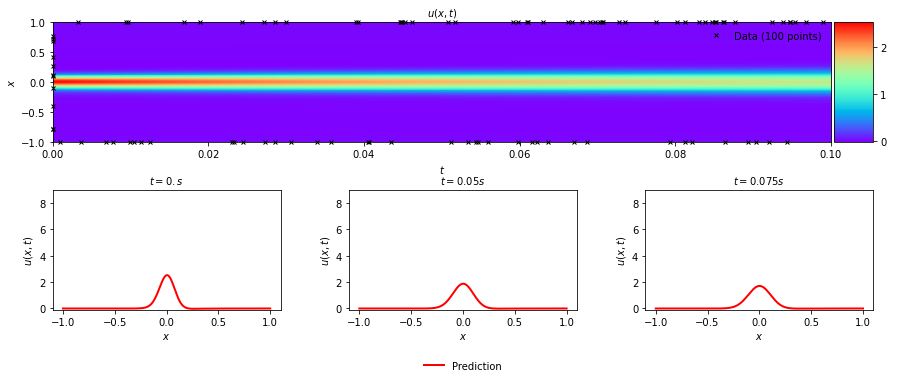

In [39]:
N_u = 100 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 1000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))

u_pred = np.reshape(u_pred,(256,1000),order='F')                        # Fortran Style ,stacked column wise!

''' Solution Plot '''
solutionplot(u_pred,X_u_train,u_train)

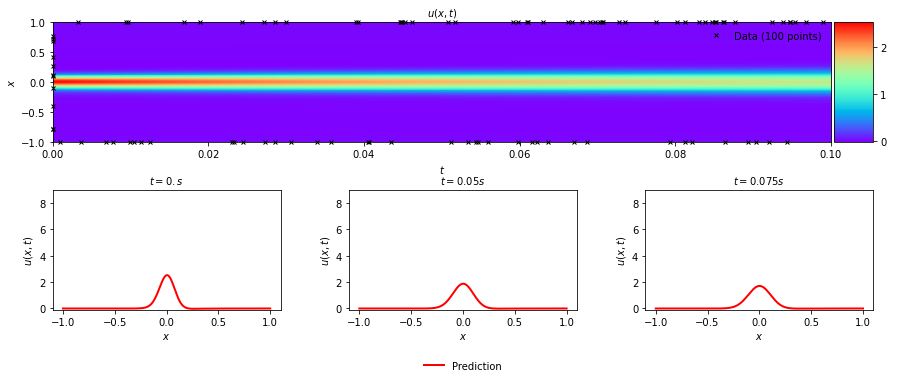

In [40]:
solutionplot(u_pred,X_u_train,u_train)

In [41]:
import pickle

filename = 'models/ornstein_uhlenbeck_central_ic.sav'
pickle.dump(results, open(filename, 'wb'))


# Plot of collocation points

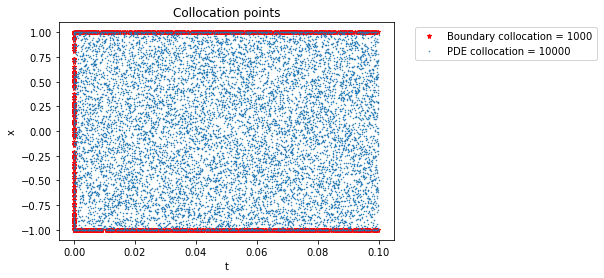

In [42]:
N_u = 1000 #Total number of data points for 'u'
N_f = 10000 #Total number of collocation points 

# Training data
X_f_train, X_u_train, u_train = trainingdata(N_u,N_f)

fig,ax = plt.subplots()

plt.plot(X_u_train[:,1], X_u_train[:,0], '*', color = 'red', markersize = 5, label = 'Boundary collocation = 1000')
plt.plot(X_f_train[:,1], X_f_train[:,0], 'o', markersize = 0.5, label = 'PDE collocation = 10000')

plt.xlabel('t')
plt.ylabel('x')
plt.title('Collocation points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

fig.savefig('collocation_points_Burgers.png', dpi = 500, bbox_inches='tight')

In [43]:

x = np.linspace(-1, 1, 256)                     # 256 points between -1 and 1 [256x1]
t = np.linspace(0, 0.1, 1000)                     # 100 time points between 0 and 1 [100x1] 

X, T = np.meshgrid(x,t)
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_pred=PINN.evaluate(X_u_test)
u_pred = np.reshape(u_pred,(256,1000),order='F')  

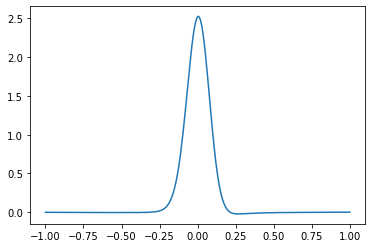

In [44]:
plt.plot(x, u_pred[:,1])


In [45]:
import ipywidgets
import pickle

filename = 'models/ornstein_uhlenbeck_central_ic.sav'
loaded_model = pickle.load(open(filename, 'rb'))

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
PINN = Sequentialmodel(layers)
PINN.set_weights(loaded_model.x)
u_pred = PINN.evaluate(X_u_test)
u_pred = np.reshape(u_pred,(256,1000),order='F')    

def inter_pred(time):
    time = int(time * 10000)
    plt.plot(x, u_pred[:,time])
    plt.xlim(-1, 1)
    plt.ylim(0, 8)
    plt.grid()
        
        
ipywidgets.interact(inter_pred, time=(0, 0.099, 0.007))

interactive(children=(FloatSlider(value=0.049, description='time', max=0.099, step=0.007), Output()), _dom_cla…

<function __main__.inter_pred(time)>